In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import klib
import natsort
import seaborn as sns
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regressor 성능 평가 지표
def RMSE(test_target, test_pred) :
    return np.sqrt(mean_squared_error(test_target, test_pred))

def MAPE(test_target, test_pred) :
	return np.mean(np.abs((test_target - test_pred) / test_target)) * 100


############################################################################################################

# Load Dataset

dataset_id = np.load(r'D:\NMDL\졸업논문\DL\input dataset\Filtered_Dataset_(20240520 종합).npz')['dataset']
dataset_parameter = np.load(r'D:\NMDL\졸업논문\Ground Truth\Ground Truth_(20240520 종합).npz')['dataset']

# Drain Current dataset + Parameter(Ground Truth) dataset 병합
## col0 to 300 : drain current / col301 : Vth / col302 : mobility / col303 : S-slope / col304 : onoff ratio
dataset_id_parameter = np.concatenate((dataset_id, dataset_parameter), axis = 1)

############################################################################################################

# train and test data split_01 - No RandomShuffle Split

####### USER SETTING ########
train_samples_ratio = 0.8 # train and test split ratio setting
ParameterNum = 304 # 301 : Vth / 302 : mobility / 303 : ss / 304 : on/off ratio # 추출하고자 하는 Parameter setting
#############################

train_size = int(dataset_id_parameter.shape[0] * train_samples_ratio)
test_size = int(dataset_id_parameter.shape[0] - train_size)

TrainDataset = dataset_id_parameter[:train_size, :]
TestDataset = dataset_id_parameter[train_size:, :]

train_input = TrainDataset[:, :ParameterNum]
train_target = TrainDataset[:, ParameterNum]
train_target = np.expand_dims(train_target, axis=1)

test_input = TestDataset[:, :ParameterNum]
test_target = TestDataset[:, ParameterNum]
test_target = np.expand_dims(test_target, axis=1)

############################################################################################################

# # train and test data split_02 - Applied RandomShuffle Split

# ###### USER SETTING ########
# train_samples_ratio = 0.8 # train and test split ratio setting
# ParameterNum = 304 # 301 : Vth / 302 : mobility / 303 : ss / 304 : on/off ratio # 추출하고자 하는 Parameter setting
# ############################

# np.random.seed(42)
# np.random.shuffle(dataset_id_parameter) # 데이터 편차 해소 위해 Shuffle
# train_size = int(dataset_id_parameter.shape[0] * train_samples_ratio)
# test_size = int(dataset_id_parameter.shape[0] - train_size)

# TrainDataset = dataset_id_parameter[:train_size, :]
# TestDataset = dataset_id_parameter[train_size:, :]

# train_input = TrainDataset[:, :301]
# train_target = TrainDataset[:, ParameterNum]
# train_target = np.expand_dims(train_target, axis = 1)

# test_input = TestDataset[:, :301]
# test_target = TestDataset[:, ParameterNum]
# test_target = np.expand_dims(test_target, axis = 1)

############################################################################################################

# Normalization - 적용해볼 만한 기법 3가지

# log10 transform

train_input = np.log10(train_input)
test_input = np.log10(test_input)

# standardization

# mean = train_input.mean(axis=0)
# std = train_input.std(axis=0)
# train_input = train_input - mean / std
# train_input /= std
# test_input = test_input - mean
# test_input /= std

# minmaxscaler

# from sklearn.preprocessing import MinMaxScaler
# minmax_scaler = MinMaxScaler()
# minmax_scaler.fit(train_input)
# train_input = minmax_scaler.transform(train_input)
# test_input = minmax_scaler.transform(test_input)


############# On/Off Ratio 학습 시 ! #############
# OnOff Ratio ground truth Normalization
train_target = np.log10(train_target)
test_target = np.log10(test_target)
############# On/Off Ratio 학습 시 ! #############

############################################################################################################

print(f'TrainDataset : {TrainDataset.shape} TestDataset : {TestDataset.shape}')
print(f'train_input : {train_input.shape} / train_target : {train_target.shape} \
test_input : {test_input.shape} / test_target : {test_target.shape}')


TrainDataset : (484, 305) TestDataset : (122, 305)
train_input : (484, 304) / train_target : (484, 1) test_input : (122, 304) / test_target : (122, 1)


In [3]:
# DNN Model setting

model = tf.keras.Sequential()
model.add(Dense(100, activation='relu', input_shape=(train_input.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(layers.Dense(50, activation='relu'))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               30500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 50,801
Trainable params: 50,801
Non-trainable params: 0
_________________________________________________________________


In [6]:
# CheckPoint(Model), Log data, Accuracy & Loss data save directory setting

####### USER SETTING ########
Model_Name = 'DNN'
Model_Info = 'OnOffRatio(real)_trainlog_lr0.001_epoch30000_Adam_logtrans_0520_SDUDATA'
#############################

# Saving Path setting

TrainingResults_Path = 'D:/NMDL/졸업논문/DL/' + Model_Name + '/TrainResults(pre)'
Network_Path = '/checkpoints/' + Model_Info
Log_Path = '/log/' + Model_Info
AccLossData_Path = '/AccuracyLossData/' + Model_Info
AccLossFigure_Path = '/AccuracyLossFigure/'
CheckPoint_Name = 'epoch{epoch:02d}-val_Loss{val_loss:.3f}-mae{mae:.3f}.h5'

# path 존재하지 않을 경우 directory 생성

if not os.path.exists(TrainingResults_Path + Network_Path) :
    os.makedirs(TrainingResults_Path + Network_Path)

if not os.path.exists(TrainingResults_Path + Log_Path) :
    os.makedirs(TrainingResults_Path + Log_Path)
    
if not os.path.exists(TrainingResults_Path + AccLossData_Path) :
    os.makedirs(TrainingResults_Path + AccLossData_Path)
    
if not os.path.exists(TrainingResults_Path + AccLossFigure_Path) :
    os.makedirs(TrainingResults_Path + AccLossFigure_Path)


In [7]:
# CheckPoint , TensorBoard, EarlyStopping Setting

callbacks = [
    ModelCheckpoint(filepath = TrainingResults_Path + Network_Path + '/' + CheckPoint_Name,
                    monitor = 'val_loss',
                    verbose = 1,
                    save_best_only = True,
                    save_weights_only =False, # model weights 만 save 할 것인지
                    mode='auto',
                    save_freq = "epoch",
                   ),
    # CSVLogger(filename = TrainingResults_Path + '/log/' + 'train-log' + Model_Info + '.csv',
    #           separator = ',',
    #           append = True
    #          ),

    TensorBoard(log_dir = TrainingResults_Path + Log_Path,
                histogram_freq = 1 # model layer에 대한 활성화 histogram 계산 여부
               ),

    # EarlyStopping(monitor = 'val_loss',
    #               patience = 100,
    #              )
]

In [ ]:
# # Model Train

####### USER SETTING ########
n_epochs = 10000
#############################

history = model.fit(train_input, train_target,
                    epochs = n_epochs, 
                    batch_size = 128,
                    validation_split=0.25,
                    callbacks = callbacks,
                   )

Epoch 1/10000
1/3 [=========>....................] - ETA: 1s - loss: 46.9013 - mae: 6.8405 - mse: 46.9013
Epoch 1: val_loss improved from inf to 5.40217, saving model to D:/NMDL/졸업논문/DL/DNN/TrainResults(pre)/checkpoints/OnOffRatio(real)_trainlog_lr0.001_epoch30000_Adam_logtrans_0520_SDUDATA\epoch01-val_Loss5.402-mae3.552.h5
3/3 [==============================] - 2s 413ms/step - loss: 20.3217 - mae: 3.5518 - mse: 20.3217 - val_loss: 5.4022 - val_mae: 2.3185 - val_mse: 5.4022
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4917 - mae: 2.5266 - mse: 6.4917
Epoch 2: val_loss improved from 5.40217 to 4.62725, saving model to D:/NMDL/졸업논문/DL/DNN/TrainResults(pre)/checkpoints/OnOffRatio(real)_trainlog_lr0.001_epoch30000_Adam_logtrans_0520_SDUDATA\epoch02-val_Loss4.627-mae1.443.h5
3/3 [==============================] - 0s 132ms/step - loss: 3.0182 - mae: 1.4428 - mse: 3.0182 - val_loss: 4.6272 - val_mae: 2.1426 - val_mse: 4.6272
Epoch 3/10000
1/3 [=========>.............

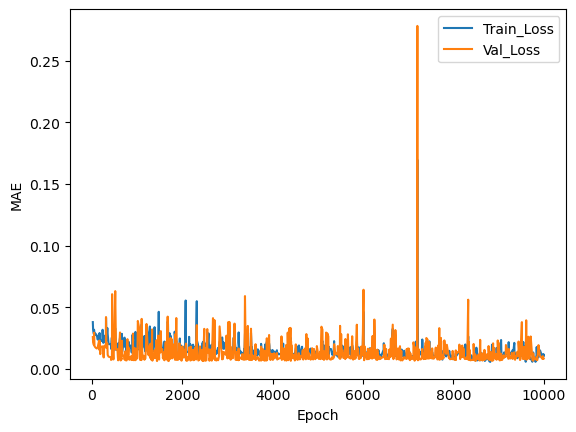

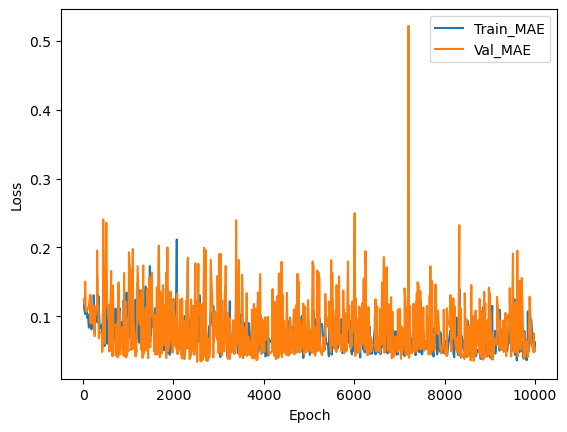

In [9]:

# Train Result Visualization setting

FileList = natsort.natsorted(os.listdir(TrainingResults_Path + AccLossData_Path))
DataName = ['Train_Loss', 'Train_MAE', 'Val_Loss', 'Val_MAE']
yLabelName = ['Loss', 'MSE', 'MAE']

for i, filename in enumerate(FileList) :
    
    AccLoss_Data = pd.read_csv(TrainingResults_Path + AccLossData_Path +'/'+ FileList[i])

    if i == 0 or i == 2 :
        plt.figure(num = 0)
        plt.plot(AccLoss_Data['Step'], AccLoss_Data['Value'], label = DataName[i])

    elif i == 1 or i == 3 :
        plt.figure(num = 1)
        plt.plot(AccLoss_Data['Step'], AccLoss_Data['Value'], label = DataName[i])

    
    plt.rc('font', size = 10)
    plt.xlabel('Epoch')
    plt.ylabel(yLabelName[i%3])
    # plt.ylim(0, 5)
    plt.legend(loc = 'upper right')
    
    if i%4 == 2 or i%4 == 3 :
        FigureName = TrainingResults_Path + AccLossFigure_Path + Model_Info + filename[:-4] + '.png'
        plt.savefig(fname = FigureName, dpi = 300)

In [10]:
# # Model Save setting

# ModelSave_Path = 'D:/NMDL/졸업논문/DL/' + Model_Name + '/Model/' + Model_Info + '/'

# if not os.path.exists(ModelSave_Path) :
#     os.makedirs(ModelSave_Path)

# model.save(ModelSave_Path)


INFO:tensorflow:Assets written to: D:/NMDL/졸업논문/DL/DNN/Model/OnOffRatio(real)_trainlog_lr0.001_epoch30000_Adam_logtrans_0520_SDUDATA/assets


In [11]:
# Model Load

model = keras.models.load_model('D:/NMDL/졸업논문/DL/' + Model_Name + '/Model/' + Model_Info + '/')

# Model Evaluate

scores = model.evaluate(test_input, test_target)
print(f'Test_Loss : ', scores[0])
print(f'Test_MAE : ', scores[1])

4/4 [==============================] - 0s 5ms/step - loss: 0.0136 - mae: 0.0437 - mse: 0.0136
Test_Loss :  0.013570635579526424
Test_MAE :  0.04374556243419647
Test_MSE :  0.013570635579526424


In [12]:
# Model Test setting

prediction = model.predict(test_input)
test_result = np.concatenate((prediction, test_target), axis = 1)
# test_result = test_result[test_result[:, 1].argsort()]

# 성능 평가 지표 값 확인

RMSE_value = RMSE(test_target, prediction[:, 0])
MAPE_value = MAPE(test_target, prediction[:, 0])
R2_value = r2_score(test_target, prediction[:, 0])
print(f'RMSE : {RMSE_value}, MAPE : {MAPE_value})


4/4 [==============================] - 0s 3ms/step
RMSE : 0.11649306523204507, MAPE : 2.4277534346993326, R-squared : 0.7820183912884233


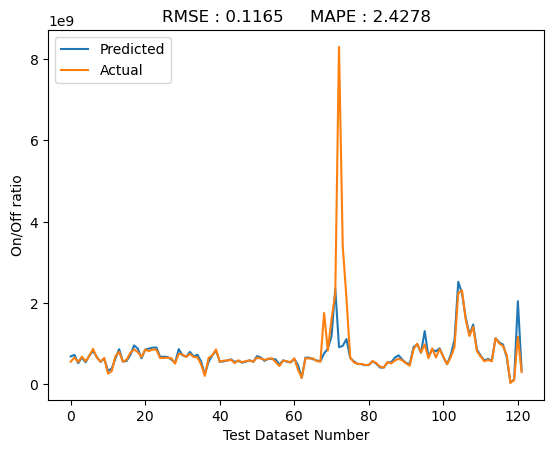

In [14]:
# Test Results Visualization setting

TestResults_Path = 'D:/NMDL/졸업논문/DL/' + Model_Name + '/TestResults(pre)/'

if not os.path.exists(TestResults_Path) :
    os.makedirs(TestResults_Path)

ParameterLabel = ['Threshold Voltage [V]', 'Saturation Mobility [cm^2/V-sec]', 'Subthreshold Slope [V/dec]', 'On/Off ratio']

plt.figure(5)
plt.title('RMSE : ' + str(np.round(RMSE_value, 4)) + '     ' +'MAPE : ' + str(np.round(MAPE_value, 4)))
plt.plot(list(range(len(prediction))), 10**test_result[:, 0], label='Predicted')
plt.plot(list(range(len(prediction))), 10**test_result[:, 1], label='Actual')
plt.xlabel('Test Dataset Number')
plt.ylabel(ParameterLabel[ParameterNum-301])
plt.legend(loc = 'upper left')
FigName_line = TestResults_Path + Model_Info + '_line' + '.png'
plt.savefig(fname = FigName_line, dpi = 300)


# plt.figure(10)
# plt.scatter(list(range(len(prediction))), prediction, label='Predicted', alpha=0.6)
# plt.scatter(list(range(len(prediction))), test_target, label='Actual', alpha=0.6)
# plt.xlabel('Test Dataset Number')
# plt.ylabel(ParameterLabel[ParameterNum - 301])
# plt.legend(loc = 'upper left')
# FigName_scatter = TestResults_Path + Model_Info + '_scatter' +'.png'
# plt.savefig(fname = FigName_scatter, dpi = 300)

# plt.figure(15)
# plt.scatter(test_target, prediction, alpha = 0.6, marker = 'x')
# plt.xlim([0, 15])
# plt.ylim([0, 15])

